<a href="https://colab.research.google.com/github/amaralcs/ET5003/blob/main/Etivity_1_Nigel_Portley_9022724.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [187]:
#@title Current Date
Today = '2021-09-15' #@param {type:"date"}


In [188]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "9022724" #@param {type:"string"}
Student_full_name = "Nigel Portley" #@param {type:"string"}
#@markdown ---

In [189]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [190]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [237]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [192]:
# Setting a seed, maintaining the random values for later runs of the code:
np.random.seed(123)

## Dataset

### Loading the MNIST 'handwritten digits' dataset

In [193]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [194]:
# Path, copy the path from your Drive
Path = '/content/drive/MyDrive/Colab Notebooks/Nigel 9022724/'

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


There are 60,000 training digit samples and 10,000 test digit samples, each is 784 bytes of information, i.e. a black and white 28 x 28 pixel image of a handwritten digit. Each pixel is a byte, with a value from 0 to 255 denoting the level of the greyscale.
Below is an example of one single digit 28 x 28 picture (the very first training example), where white space is denoted by a zero and the blackest of black by 255:

In [195]:
print (X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

Now we will normalise the values to between 0 and 1 by dividing each value by 255:

In [196]:
# Normalizing the Inputs, i.e. converting the 0-255 range to 0-1 by dividing by 255:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values, i.e. checking the range of values is within 0 and 1:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


Now all pixels are represented by a value between 0 and 1. Most ML algorithms & libraries are designed to work with values between 0 and 1 and so normalisation supports that system.

### Description of Data:

In [197]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


The classes are the different classification results, i.e. with the handwritten digits it's 0 to 9, or 10 different classes.

### Class Distribution:

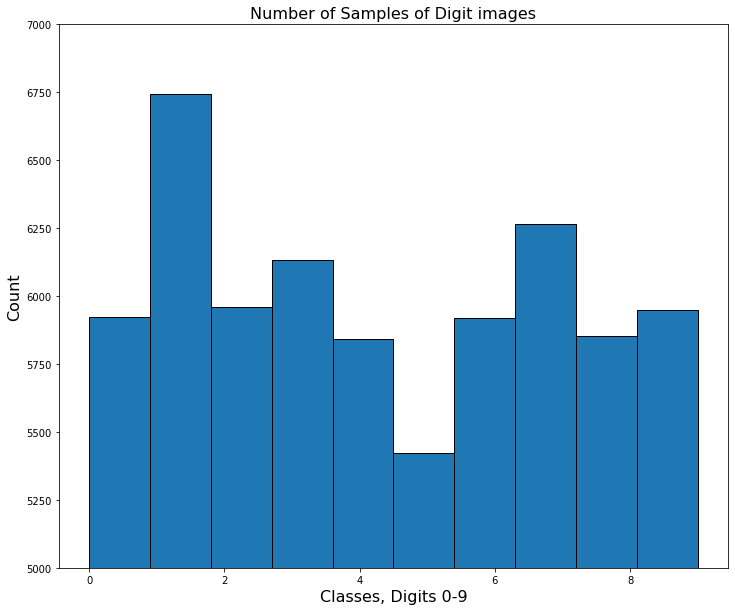

In [198]:
fig, ax = plt.subplots(figsize=(12,10))
ind = np.arange(n_classes)
n, bins, patches = ax.hist(y_train, n_classes, ec='black', align='mid')
ax.set_xlabel('Classes, Digits 0-9', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Number of Samples of Digit images', fontsize=16)
plt.ylim ((5000,7000))
plt.show()

We see there are slightly more ones than other samples. If these digits are for example from postcodes, one is the lowest non-zero digit; some streets are small and so might reach to house number 20, i.e. would have 10-19, so there are more ones than other digits.

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [199]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
print (classes)

[1, 2, 6]


Three digits are chosen. We shall now select 5000 instances of each digit to balance the data set, as some digits have just over 5000 samples, and others have over 6000.

In [200]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 5000
inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)
print (X_train,y_train)
print (X_train.shape,y_train.shape)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



So 5000 samples for three digits is 15000 samples, of size 784 (28 x 28 pixels).
There are 3 x 5000 classes, i.e. 15000 corresponding y_train classifications.

New Classes Distribution

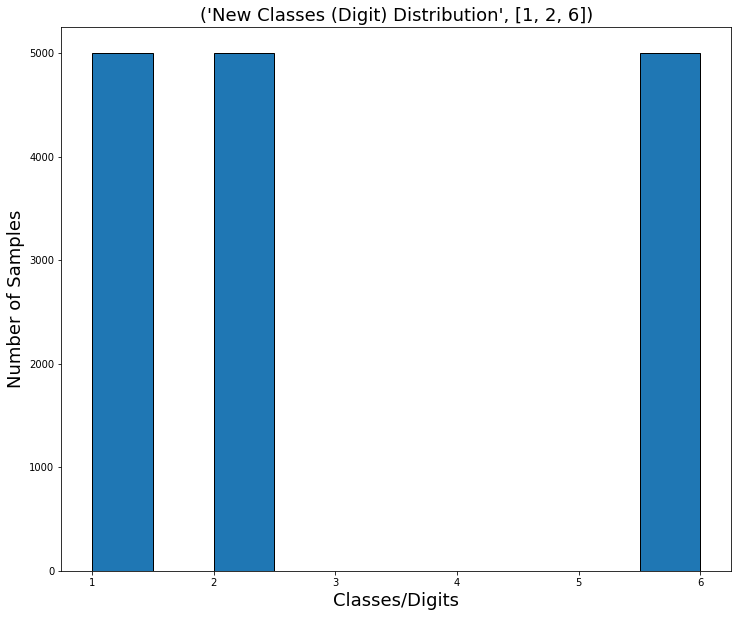

In [201]:
# new histogram
fig, ax = plt.subplots(figsize=(12,10))
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, ec='black', align='mid')
ax.set_xlabel('Classes/Digits', fontsize = 18)
ax.set_ylabel('Number of Samples', fontsize = 18)
title = 'New Classes (Digit) Distribution', classes
plt.title(title, fontsize = 18)
plt.show()

We now write a function to display a digit graphically.

In [202]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Next we take 10 digits randomly (we index X_train with a random integer between 0 and the length of X_train - 1) 

Text(0.5, 1.0, 'Original Digits')

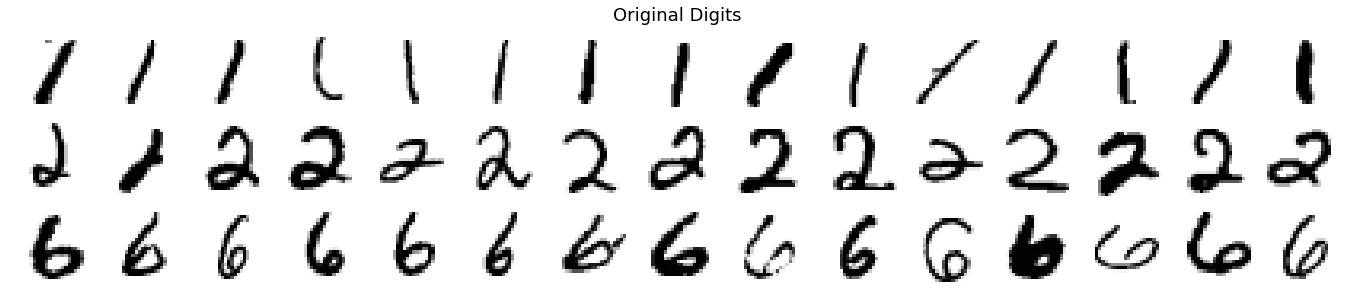

In [203]:
# Show a few instances from each Digit:
plt.figure(figsize=(24,8))
label_indices = []
# Selecting a few label indices from each of the 3 classes to show:
for i in range(30):
    # take index randomly chosen
#    label_indices.append(random.randint(0, len(X_train)))
    label_indices = np.hstack([np.random.choice(np.where(y_train==label)[0], size=15) for label in classes])
    # choose the image according to the index
    image = X_train[label_indices[i] - 1]

# Plotting 'original' image
plot_digits(X_train[label_indices],images_per_row=15)
plt.title("Original Digits", fontsize=18)

In general, the digit samples look 'clean' and rather legible, the accuracy should be quite high if these examples are anything to go by.

In [204]:
print (label_indices)

[ 3643  1073  1577  2029  1838  4032  3857  1414    86  1737   931   643
   424   462  3399  9700  7345  7065  8911  8913  8659  7112  5904  7278
  9316  6733  9096  8367  7301  7086 11086 12614 13288 12668 13300 11876
 13730 11960 11138 12550 14202 10769 13764 10719 11958]


The above indices exhibit that a very random sample of examples has been chosen.

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [205]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [206]:
# print shape of your validation and training set

print (X_train.shape,y_train.shape)
print (X_val.shape,y_val.shape)


(12000, 784) (12000,)
(3000, 784) (3000,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

In [207]:
import sklearn.preprocessing
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
np.set_printoptions(threshold=100)
y_2_bin
#y_2_bin.shape

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

### General-Recipe ML

The below cell runs the multinomial logistic regression algorithm on our data, trains a model, and calculates the accuracy of that model.

In [208]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log, y_val)

0.974

The accuracy is quite good, at circa 97%.

In [ ]:
target_names = []
for x in classes:
  target_names.append("Digit "+str((round(x,0)))

print(classification_report(y_val, y_pred_log, target_names=target_names, digits=3))

In [209]:
#np.set_printoptions(threshold=np.inf)
np.sort(prob_classmax)

array([0.42761895, 0.51284719, 0.5176237 , ..., 1.        , 1.        ,
       1.        ])

We see above some examples where the probability of an accurate classification is quite low, i.e. very difficulty samples to classify.

In [210]:
prob_classmax[y_pred_log!=y_val]
prob_classmax[y_pred_log!=y_val].shape

(78,)

There are less than 100 cases where the wrong result was selected, which is quite good.

In [236]:
np.set_printoptions(threshold=np.inf)
np.array(y_pred_log)
#np.array(y_pred_log).shape

array([1., 6., 6., 1., 2., 1., 6., 6., 2., 1., 2., 2., 1., 6., 1., 2., 1.,
       6., 6., 2., 6., 2., 2., 1., 1., 1., 6., 2., 2., 2., 2., 6., 2., 1.,
       6., 2., 6., 2., 6., 2., 6., 2., 6., 6., 1., 6., 2., 6., 6., 6., 6.,
       6., 2., 1., 2., 1., 1., 1., 6., 2., 6., 6., 2., 2., 1., 6., 2., 2.,
       2., 1., 6., 1., 2., 1., 6., 6., 2., 6., 2., 6., 6., 1., 1., 2., 6.,
       6., 6., 6., 2., 1., 1., 1., 1., 2., 6., 1., 6., 6., 1., 2., 2., 1.,
       2., 6., 6., 2., 1., 6., 6., 1., 2., 6., 2., 2., 2., 1., 6., 1., 2.,
       2., 6., 2., 1., 6., 1., 1., 1., 1., 6., 6., 2., 2., 2., 6., 6., 2.,
       6., 1., 2., 1., 2., 6., 2., 2., 1., 2., 1., 2., 2., 1., 1., 2., 2.,
       6., 6., 2., 6., 1., 1., 2., 1., 2., 6., 1., 1., 1., 1., 2., 6., 2.,
       6., 6., 6., 6., 2., 6., 2., 2., 6., 2., 6., 2., 6., 1., 1., 6., 6.,
       2., 6., 6., 1., 2., 6., 6., 2., 1., 1., 1., 6., 2., 2., 6., 2., 2.,
       6., 1., 6., 1., 6., 2., 6., 6., 1., 2., 1., 1., 6., 1., 2., 1., 2.,
       6., 6., 1., 1., 6.

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [212]:

## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
nf = X_train.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)


α and β are given a normal distribution from 0 to 1 with sigma = 100.

In [213]:
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(3000, method='advi')

Finished [100%]: Average Loss = 18,319


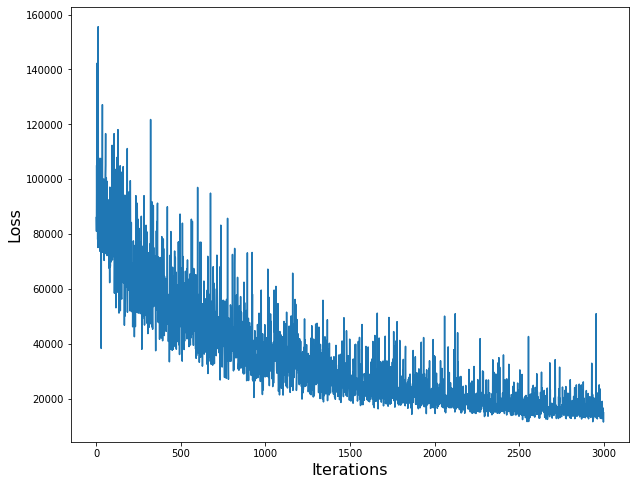

In [214]:
plt.figure(figsize=(10,8))
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(approx.hist)
plt.show()

The Histogram above displays the gradually descending loss at each iteration of the Multinomial Logistic Regression Model using PyMC3 automatic differentiation variational inference(ADVI) method. In this case, the average loss per iteration after 3000 iterations has come down roughly six or seven fold from initially ~120,000 to ~20,000.

In [215]:
# This code takes dd samples from the approximation above and passes them to the posterior.
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 6.0
classes: [1, 2, 6]
estimated prob= [0. 1. 0.]


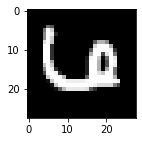

In [216]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

The softmax function is used to normalize the output of a network to a probability distribution over the predicted output classes. In our case the softmax function returns three probabilities for each digit, i.e. a probability of a digit being 1, 2 or 6. The errored case above shows that 2 is predicted although the digit is clearly supposed to be a six.

The test image example given clearly shows the reason that the example was misclassified; the digit in this case is written to it's side. In order to catch such cases like this in ML, a rotation filter in a CNN could be used, which rotates each sample through 90 degrees or otherwise in both directions and adds the resulting images to the sample space. However this is beyond the scope of the exercise.

In [217]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))


In [218]:
print(y_pred_Bayesian)

[0, 2, 2, 0, 1, 0, 2, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 2, 2, 1, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 1, 2, 2, 1, 0, 2, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 2, 1, 2, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 2, 1, 0, 0, 0, 2, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 2, 0, 2, 1, 2, 1, 1, 2, 1, 2, 2, 

In [219]:
from collections import Counter
print(Counter(y_pred_Bayesian))

Counter({1: 1030, 2: 1001, 0: 969})


We can see that from the digits 1, 2 & 6 that 2 is the most identifiable in the most cases, but 1 & 6 are not far behind - there is no clear easiest digit as the counts are quite similar.

In [220]:
# recall the classes we are using
print(classes)

[1, 2, 6]


In [221]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([1, 6, 6, 1, 2, 1, 6, 6, 2, 1])

In [222]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.937


In [223]:
## Selecting different instances

In [224]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [225]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.59942985, 0.49056657],
       [2.        , 0.64226038, 0.4769696 ],
       [2.        , 0.5598645 , 0.49459299],
       [0.        , 0.90477569, 0.2712932 ],
       [1.        , 0.93250804, 0.25514702],
       [0.        , 0.78152966, 0.39747816],
       [2.        , 0.99190387, 0.08137704],
       [2.        , 0.98026094, 0.09949874],
       [1.        , 0.9551996 , 0.17950549],
       [0.        , 0.95306906, 0.17058722]])

In [226]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[0.        , 0.50007257, 0.5       ],
       [0.        , 0.50404457, 0.5       ],
       [2.        , 0.49996043, 0.5       ],
       [1.        , 0.50028286, 0.5       ],
       [2.        , 0.49710588, 0.5       ],
       [0.        , 0.48064121, 0.5       ],
       [1.        , 0.49518554, 0.49998889],
       [1.        , 0.51345627, 0.49995555],
       [0.        , 0.5016665 , 0.49995555],
       [0.        , 0.48339428, 0.49995555]])

In [227]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log != y_val]

array([1.        , 0.9999908 , 0.99995891, 0.99981347, 0.98079807,
       0.93164146, 0.8711765 , 0.9707614 , 0.99999997, 0.51284719,
       0.92689108, 0.99915921, 0.68499082, 0.99888392, 1.        ,
       0.58931519, 0.93713587, 0.99980593, 0.92434844, 0.86367748,
       0.99999999, 0.74996053, 0.99999971, 0.99946989, 0.9999984 ,
       0.9846901 , 0.99772614, 0.99996548, 0.99977199, 0.8901548 ,
       0.85530461, 0.74915123, 0.96661533, 0.97656184, 0.67265709,
       0.63616862, 0.95337935, 0.96553302, 0.96006696, 1.        ,
       0.99699667, 0.9995172 , 0.97156277, 0.63328865, 0.99834075,
       0.98800818, 0.95565749, 0.97789174, 0.68079014, 0.99953723,
       0.93557243, 0.99999202, 0.99911817, 0.52590047, 0.99511685,
       0.99999959, 1.        , 0.9620433 , 0.89518553, 0.86479906,
       0.99530315, 0.60188496, 0.67741465, 0.9999999 , 0.98790068,
       1.        , 0.42761895, 0.9746156 , 0.99838855, 0.95922805,
       0.99944298, 0.99566734, 0.66589747, 0.67146108, 0.97809

We see that the cases where the prediction is wrong that some samples have a low probability, i.e. 0.6, but we also see a handful of sampled had a 'certain' probability of '1', where the digit sample's features matched the algorithm's prediction perfectly, however the prediction can still be wrong as the accuracy cannot be 100% with such an error-prone unpredictable dataset such as handwriting.

The below computes the number of mistakes in identifying the digits with the given model:

In [228]:
y_predB[y_pred_log != y_val,:]
len (y_predB[y_pred_log != y_val,:])

78

In [229]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:70]], y_val[easy[0:70]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:70]], y_val[difficult[0:70]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.9142857142857143


There is a *recogniseable* difference in accuracy when comparing the most easy samples to the most difficult.

In [230]:
y_pred_log.shape

(3000,)

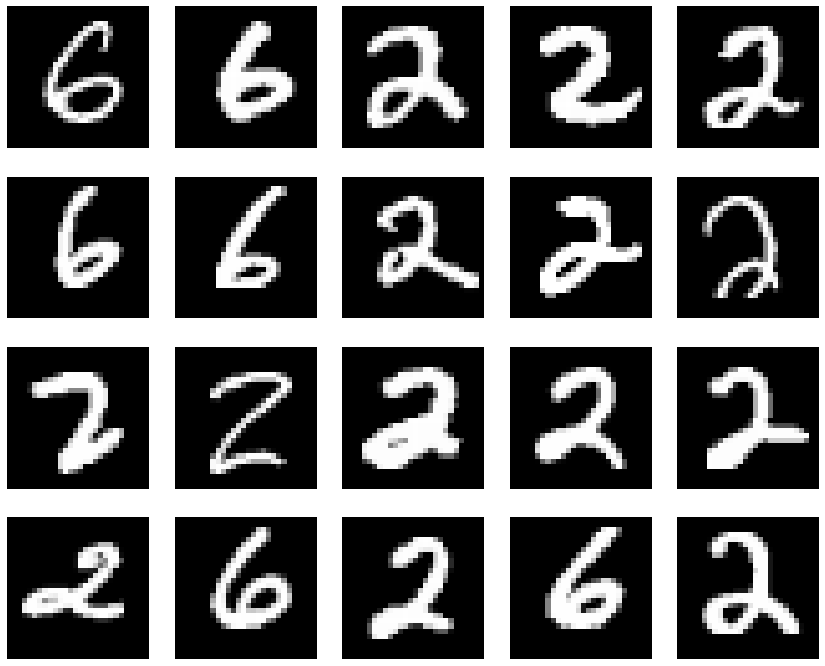

In [231]:
# show 10 random 'easy' images
fig, axs = plt.subplots(4,5, figsize=(15, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(20):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

We see above with the easy samples that there is recogniseable consistency in how the digits are drawn.

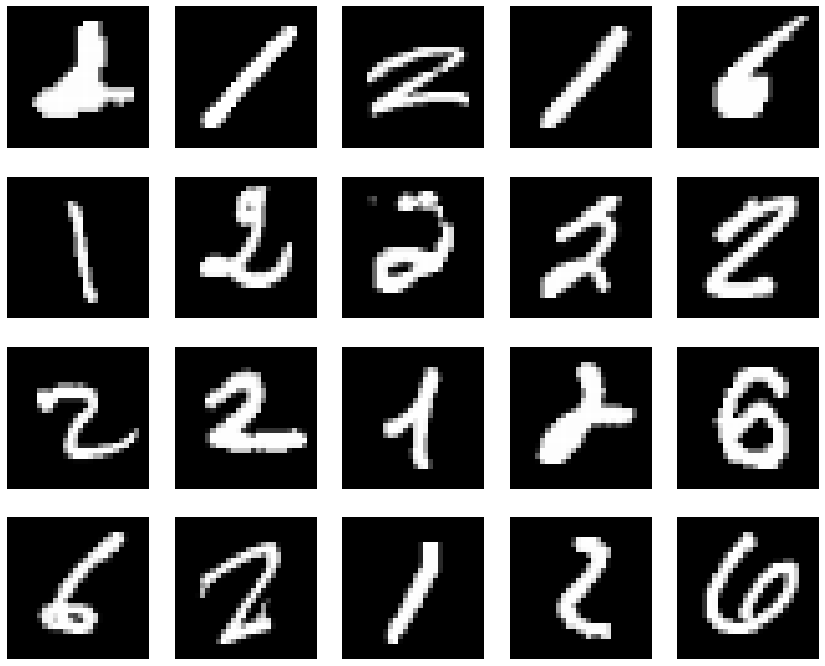

In [232]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(4,5, figsize=(15, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(20):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

In [233]:
## Re-run of multinomial logistic regression without difficult samples, but varying the number of difficult samples
## Kudos to Rob Barrett for his idea of depicting the sweetspot of difficult image removal in this way
results = []
for i in list(np.arange(100, 3000, 100)):
  # model
  model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train[easy[0:i]], y_train[easy[0:i]])

  # Classification:
  y_pred_log = model_log.predict(X_val)
  y_pred_logi_prob = model_log.predict_proba(X_val)

  # Maybe taking the maximum probability 
  # in any of the classes for each observation
  prob_classmax = np.max(y_pred_logi_prob,axis=1)

  # Computing the Accuracy:
  accuracy_score(y_pred_log, y_val)
  results.append (accuracy_score(y_pred_log, y_val))

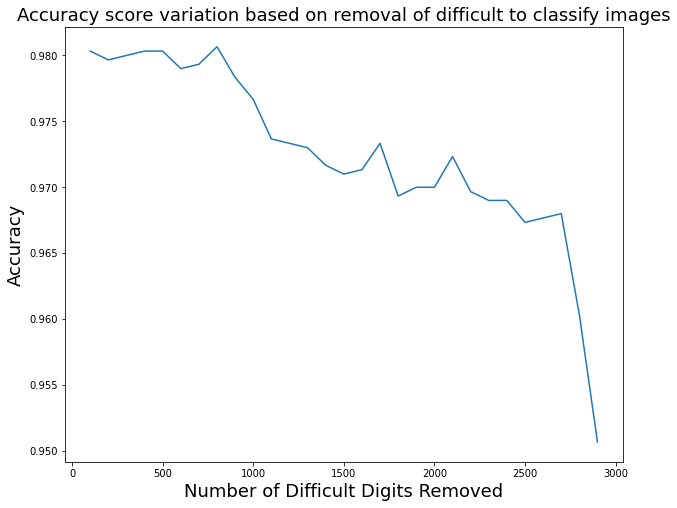

In [234]:
## Graphing the varying effects on accuracy of removing varying amounts of 
results.reverse()
plt.figure(figsize=(10,8))
plt.plot((list(np.arange(100, 3000, 100))), results)
plt.title('Accuracy score variation based on removal of difficult to classify images',fontsize=18)
plt.xlabel('Number of Difficult Digits Removed',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.show()

We can clearly see above that the removal of 500 difficult images gives the highest accuracy of the model. 
And now to re-run the multinomial logistic regression without the 500 most difficult samples:

In [235]:
## Re-run of multinomial logistic regression without difficult samples
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train[easy[0:2500]], y_train[easy[0:2500]])

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
accuracy_score(y_pred_log, y_val)

0.9803333333333333

There is a slight increase from the original accuracy measure of 0.974 when the model was formed based on all samples, to the circa 0.98 achieved when removing the 500 most difficult samples. However there were less than 100 errors in digit recognition from the three digit samples so the overall accuracy is only slightly improved - the quality of the dataset is such that most examples can be successfully recognised which explains the 'slight' improvement.

## Summary

The MNSIT dataset of handwritten digits is a fairly well balanced dataset, that lends itself to be able to accurately train a multinomial logistic regression model to recognise the digits with an accuracy of over 97%.

The removal of difficult instances to classify increases the accuracy to circa 98%.


## References
https://www.analyticsvidhya.com/blog/2020/10/how-to-choose-evaluation-metrics-for-classification-model/
https://dotnet.github.io/infer/userguide/The%20softmax%20factor.html